In [1]:
import scipy.stats as sps
from statsmodels.stats.weightstats import DescrStatsW
from statsmodels.tsa.stattools import acf 

import matplotlib.pyplot as plt 
import numpy as np
import math

from functools import lru_cache

In [2]:
@lru_cache
def get_distributions(E: float = 0, D: float = 1) -> dict[str, sps.rv_continuous]:
    unif_scale = 2 * math.sqrt(3 * D)
    unif_loc = E - unif_scale / 2
    return {
        'Norm': sps.norm(loc=E, scale=math.sqrt(D)),
        'Uniform': sps.uniform(loc=unif_loc, scale=unif_scale),
        'Exp': sps.expon(loc=E - math.sqrt(D), scale=math.sqrt(D))
    }

In [3]:
N = 2 * 10 ** 2
n = 100
DELTA = 0.2
ALPHA = 0.05

Сгенерируем сигналы

In [4]:
signals = {d_name: [d.rvs(n) for _ in range(N)] for d_name, d in get_distributions().items()}

Посчитаем для них автокорреляционную функцию

In [5]:
acfs = {d_name: [acf(signal, nlags=n-1)[1:] for signal in generated_signals] for d_name, generated_signals in signals.items()}

И доверительные интервалы для их значений

In [6]:
acfs_conf_int = {d_name: np.array(DescrStatsW(acf_values).tconfint_mean(ALPHA)) for d_name, acf_values in acfs.items()}

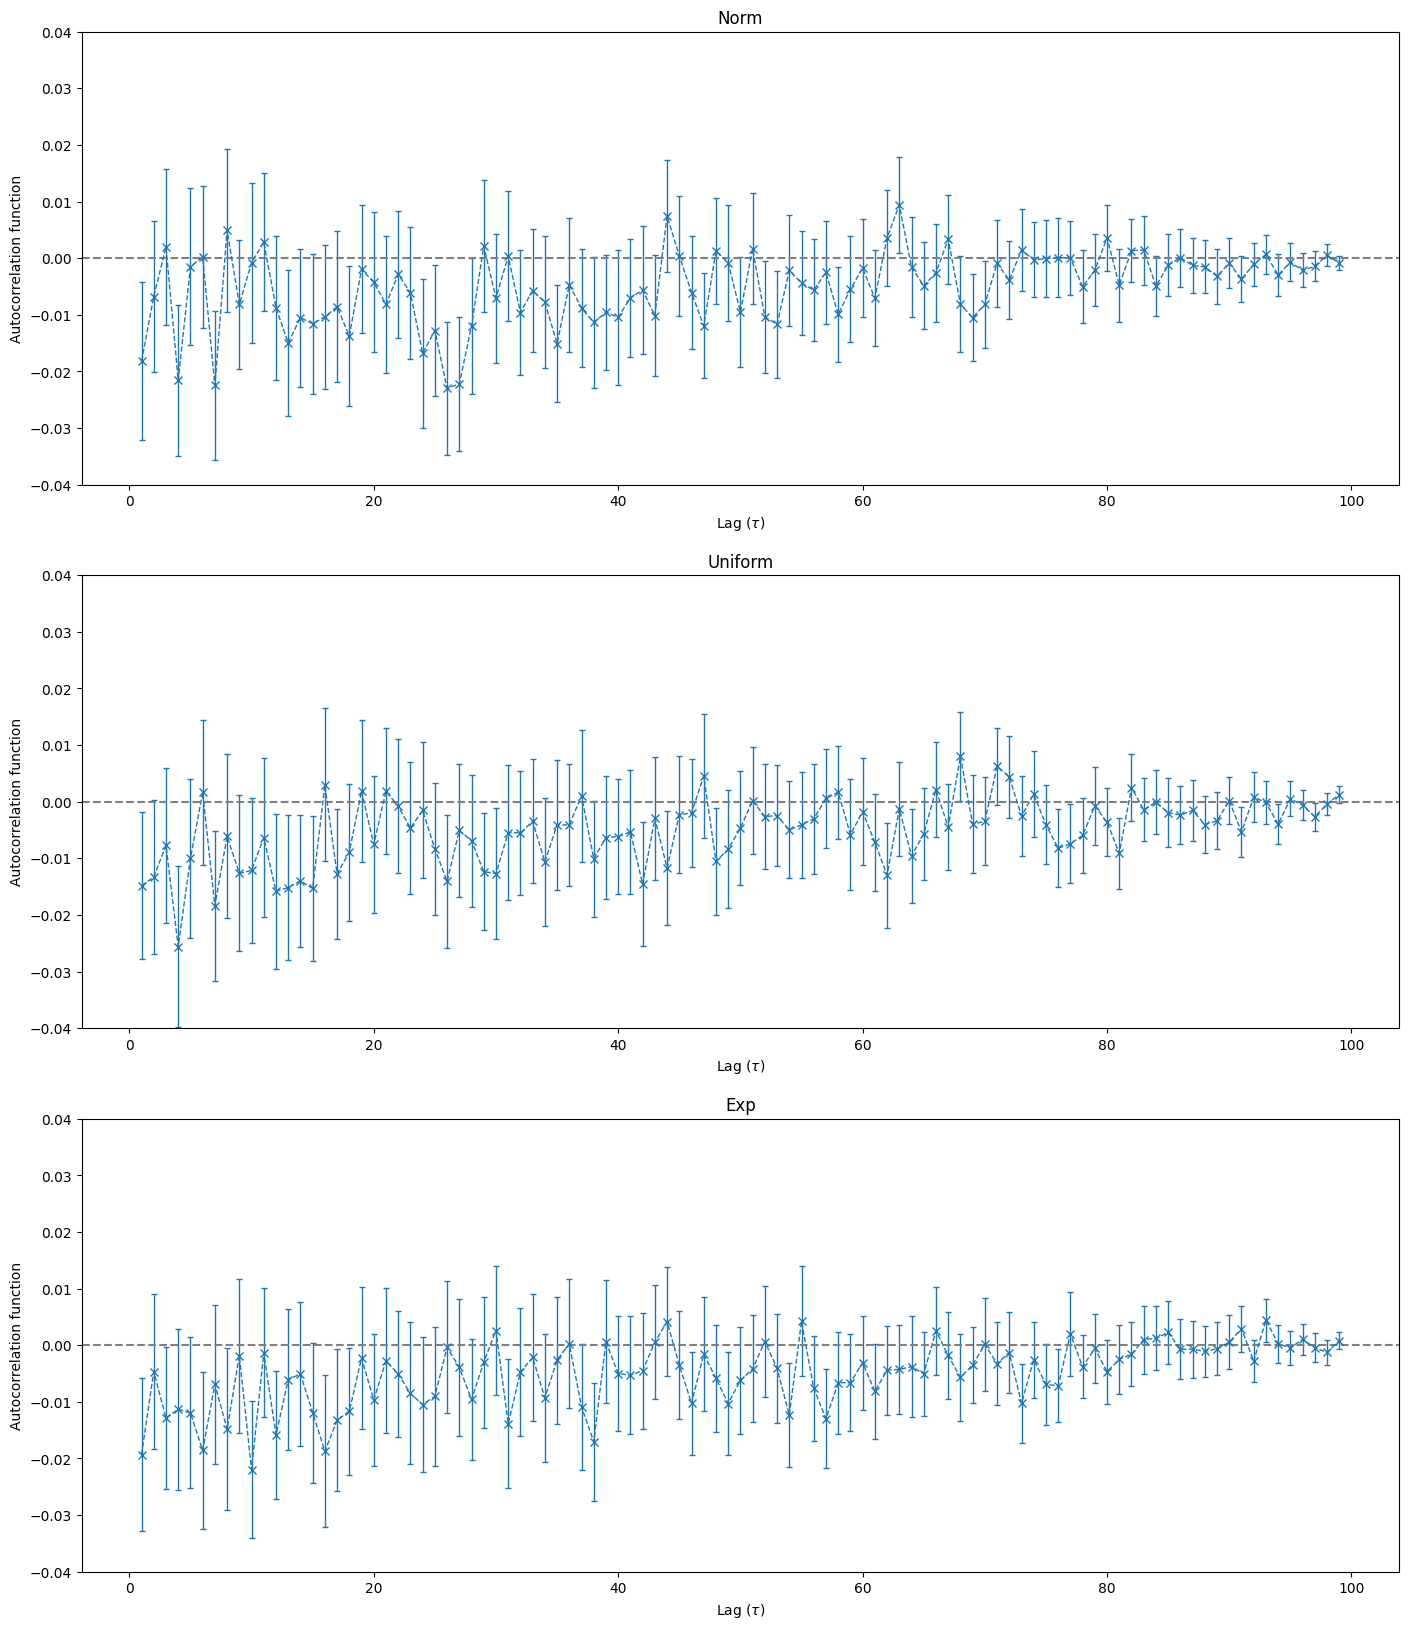

In [7]:
_, axes = plt.subplots(3, 1, figsize=(17, 20))
for i, (d_name, acf_values) in enumerate(acfs.items()):
    ax: plt.Axes = axes[i]
    mean_acf_values = np.mean(acf_values, axis=0)
    ax.errorbar(list(range(1, n)), mean_acf_values, yerr=np.abs(acfs_conf_int[d_name] - mean_acf_values), fmt='x--', linewidth=1, capsize=2)
    ax.axhline(0, linestyle='--', color='gray')
    ax.set_ylim(-4e-2, 4e-2)
    ax.title.set_text(d_name)
    ax.set_ylabel('Autocorrelation function')
    ax.set_xlabel('Lag ($\\tau$)')

Как и ожидалось, чем больше сдвиг $\tau$, тем ближе к нулю автокорреляционная функция

Теперь оценим функцию распределения минимальных значений $\tau_0 = \min\{\tau \mid 0 \in I_{A(\tau)}\}$

In [8]:
acfs_all_conf_ints = {d_name: [acf(signal, nlags=n-1, alpha=ALPHA)[1] for signal in generated_signals] for d_name, generated_signals in signals.items()}

In [9]:
tau_values = {d_name: [min([ind + 1 for ind, (low, high) in enumerate(d_acfs_cond_int) if low <= 0 <= high]) for d_acfs_cond_int in d_acfs_all_conf_ints] for d_name, d_acfs_all_conf_ints in acfs_all_conf_ints.items()}

Эмпирические функции распределения

In [10]:
ecdfs = {d_name: sps.ecdf(taus).cdf for d_name, taus in tau_values.items()}

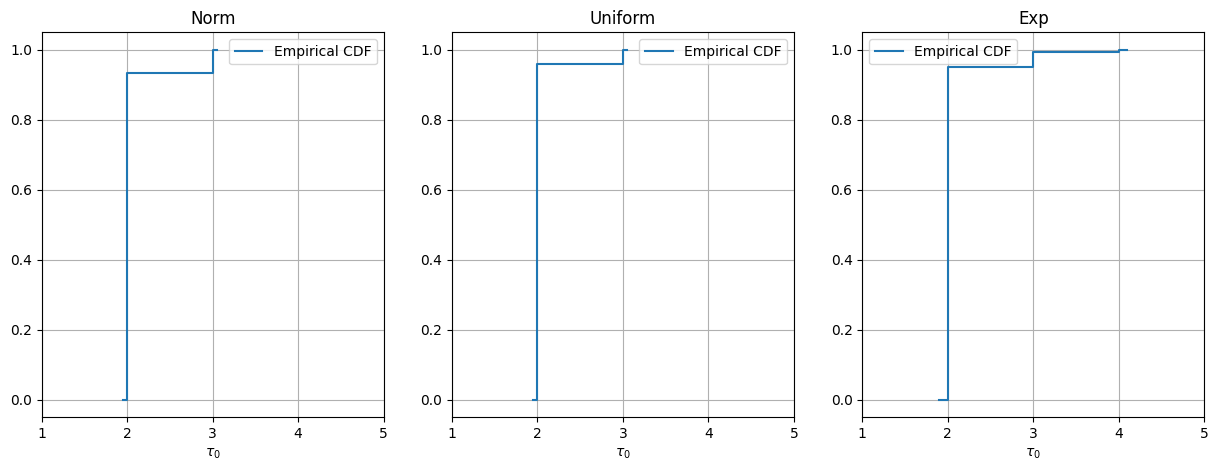

In [11]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (d_name, ecdf) in enumerate(ecdfs.items()):
    ax: plt.Axes = axes[i]
    ecdf.plot(ax, **{'label': 'Empirical CDF'})
    ax.title.set_text(d_name)
    ax.set_xlabel('$\\tau_0$')
    ax.grid()
    ax.legend()
    ax.set_xticks(ticks=list(range(1, 6)))
    ax.set_xlim(1, 5)

Как видно, значения очень быстро становятся единицей. Это и не удивительно, поскольку автокорреляционная функция является мерой случайности сигнала, а значит в нашем случае (полностью случайный сигнал), она должна зануляться почти сразу, а следовательно $\tau_0$ будут очень маленькими, что мы и наблюдаем.